In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [12]:
#Load the dataset, take a look at the data info: 
df_1 = pd.read_csv('Data/DF_1_clean.csv')
df_1.set_index('Date', inplace=True)
df_2 = pd.read_csv('Data/DF_2_clean.csv')
df_2.set_index('Date', inplace=True)
df_3 = pd.read_csv('Data/DF_3_clean.csv')
df_3.set_index('Date', inplace=True)

# Resort 1

### First Simple Model
Linear Regression with Cross Validation: 

In [17]:
#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
y.head()

Date
2017-12-21    432.0
2017-12-22     48.0
2017-12-23    266.0
2017-12-24    283.0
2017-12-25    281.0
Name: TOTAL_VISITS, dtype: float64

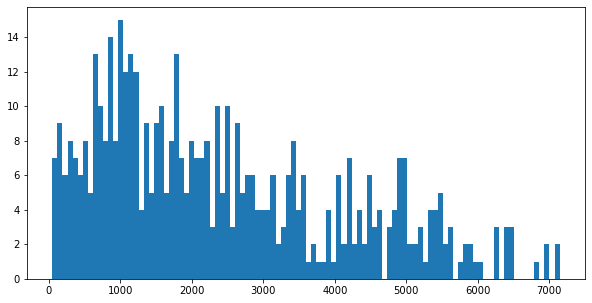

In [9]:
#visualization of target - Visits
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(y, bins=100);


In [52]:
#Split into test and train X and Y
# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']


Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#setting up the pipe and training the model: 

LRPipe = Pipeline([('trans', Transformer),
                ('linreg', LinearRegression())])

LRPipe.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(LRPipe, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(LRPipe, X_train, y_train, cv = 3)

print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores: {'fit_time': array([0.03071475, 0.02022409, 0.01680207]), 'score_time': array([0.01969409, 0.01070786, 0.01736093]), 'test_score': array([0.5191252 , 0.62466792, 0.58351552]), 'train_score': array([0.68967982, 0.6480419 , 0.67978087])}
mean CV Score: 0.5757695427323862


With Encoding and scaling, the Basic Linear Regression CV score is 0.576

There is definitly some room for improvement! 

## Tree Regressor

In [53]:
#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)
# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

dtr = DecisionTreeRegressor(random_state=42)

TreeRegPipe = Pipeline([('trans', Transformer),
                        ('dtr', dtr)])

dtr_param_grid = {
	'dtr__splitter': ['best', 'random'],
    'dtr__min_samples_split': [4, 6, 8, 10],
    'dtr__max_depth': [4, 5, 6, 7, 8]
}		

#set up gridsearch:
TreeGrid = GridSearchCV(estimator=TreeRegPipe,
						  param_grid=dtr_param_grid,
						  cv=3)

TreeGrid.fit(X_train, y_train)

#cross validation and scoring
cv = cross_validate(TreeGrid, X_train, y_train, return_train_score=True, cv=3)
cv_score = cross_val_score(TreeGrid, X_train, y_train, cv = 3)

print("Best Parameter Combination for Tree Regressor Found During Grid Search:")
print(TreeGrid.best_params_)

print(f'Tree Grid Cross Validation Scores: {cv}')

print(f'Tree Grid mean CV Score: {cv_score.mean()}')

Best Parameter Combination for Tree Regressor Found During Grid Search:
{'dtr__max_depth': 7, 'dtr__min_samples_split': 4, 'dtr__splitter': 'random'}
Tree Grid Cross Validation Scores: {'fit_time': array([1.44814777, 1.59295106, 1.34851599]), 'score_time': array([0.00744104, 0.00423503, 0.00344419]), 'test_score': array([0.20641746, 0.36846708, 0.25911523]), 'train_score': array([0.79057602, 0.60999337, 0.86411984])}
Tree Grid mean CV Score: 0.27799992205368745


Tree Regressor did not perform well with the best score of .278 in comparison to linear regression with a score of .576

## Random Forests 

In [54]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

# #Split into test and train X and Y
# X = df_3_preprocessed.drop(columns=['TOTAL_VISITS'])
# y = df_3_preprocessed['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month]
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])

#set up grid search paramater grid
rfr_param_grid = {
    'dtr__n_estimators': [2, 4, 6, 8, 10, 12, 14, 16],
    'dtr__max_depth': [None, 2, 3, 4, 5, 6, 8, 10],
	'dtr__max_features': ['auto', 'sqrt', 'log2'],
	'dtr__criterion': ['mse', 'mae']
}

#set up gridsearch:
gridsearch2 = GridSearchCV(estimator=pipeline_3,
						  param_grid=rfr_param_grid,
						  cv=3)

#fit gridsearch
gridsearch2.fit(X_train, y_train)


print("Best Parameter Combination Found During Grid Search:")
print(gridsearch2.best_params_)

Best Parameter Combination Found During Grid Search:
{'dtr__criterion': 'mse', 'dtr__max_depth': None, 'dtr__max_features': 'sqrt', 'dtr__n_estimators': 10}


In [55]:
#pipeline_3:
from sklearn.ensemble import RandomForestRegressor

#Split into test and train X and Y
X = df_1.drop(columns=['TOTAL_VISITS'])
y = df_1['TOTAL_VISITS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
rfr = RandomForestRegressor(criterion = 'mse', max_depth = None, max_features = 'sqrt', n_estimators = 10, random_state = 42)

#pipeline
pipeline_3 = Pipeline([('transformer', Transformer),
						('dtr', rfr)])


pipeline_3.fit(X_train, y_train)

cv = cross_validate(pipeline_3, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_3, X_train, y_train, cv = 5)
print(f'Cross Validation Scores best Random Forest Regressor: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores best Random Forest Regressor: {'fit_time': array([0.03267002, 0.03446102, 0.02223897, 0.022439  , 0.02221012]), 'score_time': array([0.00845098, 0.0072639 , 0.00570393, 0.0049789 , 0.00470185]), 'test_score': array([0.55986679, 0.67336618, 0.74058046, 0.6732444 , 0.54516542]), 'train_score': array([0.92655425, 0.91821211, 0.9111    , 0.90889369, 0.91310719])}
mean CV Score: 0.6384446490641958


For Resort 1, forests are performing better than trees with a CV score of .638!

## Gradient Boosting: 

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

#pipeline_4:

#Split into test and train X and Y
# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
GBR = GradientBoostingRegressor(random_state = 42)

#pipeline
pipeline_4 = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

#set up grid search paramater grid
gbr_param_grid = {
    'gbr__n_estimators': [50, 100, 200, 300],
    'gbr__criterion': ['friedman_mse', 'mse', 'mae'],
	'gbr__min_samples_split': [2, 3, 4, 5]
}

#set up gridsearch:
gridsearch3 = GridSearchCV(estimator=pipeline_4,
						  param_grid=gbr_param_grid,
						  cv=5)


#fit gridsearch
gridsearch3.fit(X_train, y_train)

print("Best Parameter Combination Found During Gradient Boosting Grid Search:")
print(gridsearch3.best_params_)


Best Parameter Combination Found During Gradient Boosting Grid Search:
{'gbr__criterion': 'mse', 'gbr__min_samples_split': 5, 'gbr__n_estimators': 200}


In [60]:
#Using best params on a gradient booster regressor then scoring thorugh cross val: 

#column transformer - this sets up simmilar to pipeline (scaler and transformer)

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	# ('scaler', StandardScaler(), non_cat), #no need to scale on Trees
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
# GBR = GradientBoostingRegressor(criterion='mse', n_estimators=200, random_state = 42)
GBR = GradientBoostingRegressor(criterion='mse', n_estimators=200, min_samples_split= 5, random_state = 42)

#pipeline
pipeline_gbr = Pipeline([('transformer', Transformer),
						('gbr', GBR)])

pipeline_gbr.fit(X_train, y_train)


cv = cross_validate(pipeline_gbr, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(pipeline_gbr, X_train, y_train, cv = 5)
print(f'Cross Validation Score Gradient Boosting Model: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Score Gradient Boosting Model: {'fit_time': array([0.15578222, 0.23252821, 0.2434392 , 0.20862627, 0.135427  ]), 'score_time': array([0.00411487, 0.01205611, 0.0044539 , 0.00767064, 0.00711298]), 'test_score': array([0.62728481, 0.68505887, 0.6747616 , 0.7939104 , 0.6750317 ]), 'train_score': array([0.96385551, 0.96685321, 0.96533828, 0.95868339, 0.96596248])}
mean CV Score: 0.6912094773793598


### Gradient Booster Regressor is doing the best: 

And more improvement! We got our average model CV score up to .691

In [61]:
import xgboost as xg

from sklearn.ensemble import GradientBoostingRegressor

#x_boost Pipe:

# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer

# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: treeregressor
xgb_r = xg.XGBRegressor(seed = 123)

#pipeline
xboostPipe = Pipeline([('transformer', Transformer),
						('xgb_r', xgb_r)])

# objective ='reg:squarederror', n_estimators = 10, 
boost_param_grid = {
    'xgb_r__eta': [.2, .3, .4, .5, .6, .7, .8],
	'xgb_r__max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
}

gridsearch_boost = GridSearchCV(estimator=xboostPipe,
						  param_grid=boost_param_grid,
						  cv=5)

#fit gridsearch
gridsearch_boost.fit(X_train, y_train)

print("Best Parameter Combination Found During Grid Search:")
print(gridsearch_boost.best_params_)

Best Parameter Combination Found During Grid Search:
{'xgb_r__eta': 0.2, 'xgb_r__max_depth': 3}


In [62]:
#x_boost Pipe with ideal paramaters:

# X = df_1.drop(columns=['TOTAL_VISITS'])
# y = df_1['TOTAL_VISITS']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline first step: Transformer
# cat = ['is_school_out', 'is_holiday', 'day_of_week_num', 'month']
# non_cat = ['T - AWND', 'T - PRCP', 'T - SNOW', 'T - SNWD', 'T - TAVG', 'M_PRCP', 'M_SNWD', 'M_TAVG']

Transformer = ColumnTransformer([
	('ohe', OneHotEncoder(), cat),
	('scaler', StandardScaler(), non_cat),
	], remainder ='passthrough')

#Pipeline second Step: 
xgb_r_2 = xg.XGBRegressor(eta = 0.2, max_depth = 3, seed = 123)

xboostPipe_2 = Pipeline([('transformer', Transformer),
						('xgb_r_2', xgb_r_2)])

xboostPipe_2.fit(X_train, y_train)

cv = cross_validate(xboostPipe_2, X_train, y_train, return_train_score=True, cv=5)
cv_score = cross_val_score(xboostPipe_2, X_train, y_train, cv = 5)
print(f'Cross Validation Scores: {cv}')

print(f'mean CV Score: {cv_score.mean()}')

Cross Validation Scores: {'fit_time': array([0.05852914, 0.06314206, 0.0524509 , 0.06174397, 0.04611087]), 'score_time': array([0.00832796, 0.00838494, 0.00914121, 0.00887918, 0.00872517]), 'test_score': array([0.63686313, 0.70759651, 0.71270877, 0.7883116 , 0.6599786 ]), 'train_score': array([0.95631625, 0.96415222, 0.96199409, 0.95670808, 0.96122295])}
mean CV Score: 0.701091719734643


X boost for resort 1 is preforming slightly better than Gradient Booster Regressor at CV score of .701

## Evaluation

**XBoost** 

In [63]:
#GBR Test Score
xboostPipe_2.score(X_test, y_test)

0.7818851261431787

XBoost gets a test CV score of .782, this means we can account for 78% of the variance in the Resort 1 data with our Gradient Booster Regressor model. 

In [65]:
y_pred_xboost = xboostPipe_2.predict(X_test)

df = pd.DataFrame({'Real Visits Resort 1':y_test, 'Predicted XBoost Visits':y_pred_xboost, 
                    'Difference': abs(y_test - y_pred_xboost)})
df.head()


,Real Visits Resort 1,Predicted XBoost Visits,Difference
Date,,,
2021-02-07,4612.0,4164.014648,447.985352
2021-04-04,887.0,1871.096924,984.096924
2019-02-20,2769.0,3016.289795,247.289795
2021-03-07,4072.0,3139.466309,932.533691
2020-01-27,1393.0,2205.445312,812.445312


In [66]:
df['Difference'].mean()

682.2084655761719

In [69]:
ohe = xboostPipe_2.named_steps["transformer"].transformers_[0][1].get_feature_names()
numbers = non_cat

columns = [*ohe, *numbers]

for name, importance in zip(columns, xboostPipe_2['xgb_r_2'].feature_importances_):
    print(name, importance)


x0_0 0.10317365
x0_1 0.0
x1_0 0.023376193
x1_1 0.0
x2_0 0.020765841
x2_1 0.057336442
x2_2 0.0019764253
x2_3 0.0025452178
x2_4 0.0350706
x2_5 0.13947353
x2_6 0.1654163
x3_1 0.0370424
x3_2 0.037307676
x3_3 0.045449104
x3_4 0.040754948
x3_11 0.08848914
x3_12 0.012864601
T - AWND 0.010084906
T - PRCP 0.0097507825
T - SNOW 0.01947744
T - SNWD 0.014582939
T - TAVG 0.059271418
M_PRCP 0.0070099
M_SNWD 0.050687484
M_TAVG 0.018093089


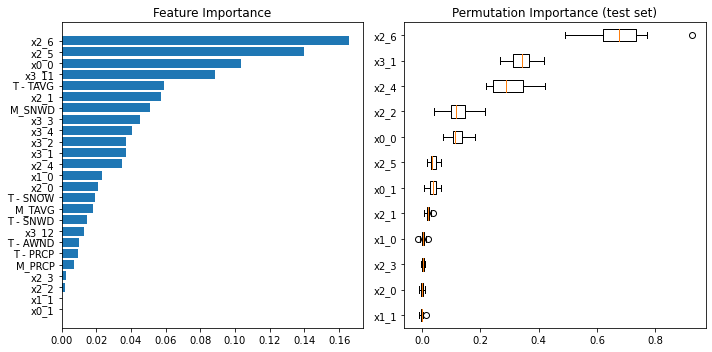

In [75]:
from sklearn.inspection import permutation_importance

feature_importance = xboostPipe_2['xgb_r_2'].feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(columns)[sorted_idx])
plt.title("Feature Importance")

result = permutation_importance(
    xboostPipe_2, X_test, y_test, n_repeats=19, random_state=42, n_jobs=2
)
result
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Resort 2 Modeling